<div style="text-align: center; font-size:200%"> Tutorial: Analyze What Makes a Good Valorant Player </div>
<br>
<div style="text-align: center; font-size:200%"> with These Cool Python Datascience Techniques! </div>
<br>
<div style="text-align: center; font-size:200%"> CMSC 320 </div>
<br>
<div style="text-align: center; font-size:200%"> Michael Suehle and Nathan Valencia </div>

# Introduction
With the end of the first international Valorant competitive event finally coming to a close and with there being several different highlight moments that will define the scene for many years to come, there are a lot of things that can be digested from a statistician’s point of view.  When looking at a top down view of a game, one would see that there are a lot of intricacies to team play including compositions, shotcalling, memorizing a team’s gameplan, individual explosive moments, utility combinations, divisions of members, and so much more.  But what describes a good player?  What makes a person stand out on the characters they perform on?  And how does this impact a game?  These are the questions we will be looking at when discussing this topic and using the data from the vlr website.  There are a lot more things to come up from a player than just kills, so let us bring into the limelight the kinds of things that people should be more aware of when discussing this game and its athletes.

# The Data
The first thing that we need to do is grab usable information and data to help support our arguments and findings.  The best place to do this is vlr.gg.  This is an unofficial website that keeps tracks of several different things that happen in game for each player.   However, there is a main statline of what this website keeps tracks of and that is how good a person can shoot at another person without dying.  The main stats that are kept on this website are as follows: kd, acs, adr, kpr, apr, fkpr, fdpr, hs%, cl%. Each of which will be discussed below
KD: Kills / Death
ACS: (Kills (point distribution by how many people are left) + Multikills (Additional 50 points for each kill after 1) + total damage).  Then it is averaged for each round at the end of the game
ADR: Damage / Round
KPR: Kills/Round
APR: Assists / Round
FKPR: First kill / Round
FDPR: First Death / Round
HS%: Headshot Kills / Kill
CL%: Clutches / rounds in ‘x’ vs 1 situation

These stats will help gather a better outline of the players and how they perform on respective rolls.  The last thing that will be included in the graph are the agents/heroes each person primarily played.  We will count the top 3 agents that a person played.  This will reign in a lot of the data and flexible players who can play a multitude of roles will be accounted for each character they use dependent on the role we are analyzing.  So before going through each of the datasets, we need to establish those roles and what they are known for.

The first up are Sentinels.  These are the people that are expected to lockdown avenues and sites as well as expected to watch flanks so the team can focus on their main objectives.  They aren’t looked at to get a lot of kills and are mainly looked to for helping set up the rest of the team.  The next role would be the controllers.  These kinds of characters control the area that is being fought over by placing smokes in key areas to slow the aggression of the enemy team and allow the rest of the team to move safely from destination to destination.  These types of players are also not expected to get many kills and are reasonably used to help control areas and stay alive to keep controlling places that need presence.  Initiators are known for their information gathering skills.  They are said to “initiate” the fight by scanning areas, flashing out corners, de-buffing the enemy team, scouting portions of the map and in general being the first sets of util that set up an execute of a plan.  These people focus on their initial usage of utility but can also get kills.  As such, they are seen as the second fraggers behind the main stars of the show.  And those would be the duelists.  Duelists’ main job is to secure map control through the elimination of the opposing team.  They are the first bodies to take fights and should always be the first out of main chokes and areas.  They are equipped with utility to help themselves secure kills as well as push up deeper into enemy territory and hold aggressive angles.  The team helps set them up to succeed in getting into positions to get those kills, but the actual act of dispatching the enemy is normally done by this role.

# Data Collection
Here we scrape the website for the table we need. We do this easily using code from project 1.

In [8]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from IPython.core.display import HTML,display

val_request = requests.get('https://www.vlr.gg/stats/?event_group_id=all&event_id=926&series_id=all&region=all&country=all&min_rounds=1&min_rating=0&agent=all&map_id=all&timespan=90d') 

root = BeautifulSoup(val_request.content, 'html.parser')
table = root.find('table')

Note that the agents are not read in. We should do something about that
also note that clutch percentage has missing data where it should be 0, so we will will that in too

In [9]:
val_data = pd.read_html(str(table))[0]
val_data.tail()

,Player,Agents,Rnd,ACS,K:D,KAST,ADR,KPR,APR,FKPR,FDPR,HS%,CL%,CL,KMax,K,D,A,FK,FD
55,FNS OPTC,(+2),468,162.3,0.81,68%,109.0,0.56,0.25,0.07,0.06,21%,13%,6/48,21,261,323,116,33,26
56,bnj NIP,NaN,147,159.9,0.86,68%,108.8,0.56,0.25,0.05,0.07,25%,29%,8/28,19,82,95,37,8,10
57,mindfreak PRX,NaN,209,158.4,0.79,70%,101.6,0.56,0.38,0.03,0.05,26%,16%,4/25,17,116,147,80,7,11
58,Meddo G2,NaN,128,152.8,0.76,64%,97.6,0.54,0.12,0.02,0.08,27%,5%,1/22,20,69,91,15,3,10
59,Boaster FNC,NaN,85,133.8,0.54,62%,88.1,0.44,0.32,0.04,0.12,17%,NaN,0/11,12,37,69,27,3,10


In [10]:
#change NaN in CL% to 0
val_data['CL%'] = val_data['CL%'].replace(np.nan, '0%')

#lets get those agents
agent_table = table.findAll('td','mod-agents')
agents_col = []

for row in agent_table:
    agents = []

    for img in row.findAll('img'):
        agents.append('<img src="https://www.vlr.gg'+img['src']+'" width="30" >')
    
    agents_col.append(agents)

val_data['agent_img_tags'] = agents_col
display(HTML(val_data.head().to_html(escape=False)))

,Player,Agents,Rnd,ACS,K:D,KAST,ADR,KPR,APR,FKPR,FDPR,HS%,CL%,CL,KMax,K,D,A,FK,FD,agent_img_tags
0,ScreaM TL,NaN,243,260.5,1.22,75%,164.6,0.86,0.31,0.16,0.08,33%,16%,3/19,24,210,172,75,39,20,"[, , ]"
1,yay OPTC,NaN,468,252.3,1.32,73%,158.4,0.89,0.15,0.17,0.14,26%,11%,5/45,30,417,317,69,78,66,"[, ]"
2,Sayaplayer TGRD,NaN,108,251.0,1.27,69%,156.9,0.88,0.14,0.19,0.18,27%,0%,0/15,27,95,75,15,20,19,"[, ]"
3,Jinggg PRX,(+1),209,250.6,1.10,67%,166.6,0.88,0.24,0.12,0.14,16%,14%,1/7,28,184,168,51,25,30,"[, , ]"
4,aspas LLL,NaN,240,249.3,1.26,76%,153.0,0.88,0.15,0.14,0.16,26%,13%,3/23,29,211,168,35,34,39,"[, ]"


### Data Wrangling
Here we add the names of the agents along with their classes.

Below I am going to fill the Agents column with names of the agents

In [11]:
import re
import math

new_agents = []
for i, row in val_data.iterrows():
    agent_names = []
    img_tags = row['agent_img_tags']
    for tag in img_tags:
        match = re.search(r'<img src="https:\/\/www\.vlr\.gg\/img\/vlr\/game\/agents\/([A-Za-z]+)\.png" width="30" >', tag)
        agent_names.append(match.group(1))
        
    if isinstance(row['Agents'], str):
        agent_names.append(row['Agents'])
        
    new_agents.append(agent_names)

val_data.drop('Agents', axis=1)
val_data['Agents'] = new_agents
display(HTML(val_data.head().to_html(escape=False))) #in final proj, we should print the table as little as possible but this is here for testing

,Player,Agents,Rnd,ACS,K:D,KAST,ADR,KPR,APR,FKPR,FDPR,HS%,CL%,CL,KMax,K,D,A,FK,FD,agent_img_tags
0,ScreaM TL,"[jett, kayo, sage]",243,260.5,1.22,75%,164.6,0.86,0.31,0.16,0.08,33%,16%,3/19,24,210,172,75,39,20,"[, , ]"
1,yay OPTC,"[chamber, jett]",468,252.3,1.32,73%,158.4,0.89,0.15,0.17,0.14,26%,11%,5/45,30,417,317,69,78,66,"[, ]"
2,Sayaplayer TGRD,"[jett, raze]",108,251.0,1.27,69%,156.9,0.88,0.14,0.19,0.18,27%,0%,0/15,27,95,75,15,20,19,"[, ]"
3,Jinggg PRX,"[reyna, raze, kayo, (+1)]",209,250.6,1.10,67%,166.6,0.88,0.24,0.12,0.14,16%,14%,1/7,28,184,168,51,25,30,"[, , ]"
4,aspas LLL,"[jett, raze]",240,249.3,1.26,76%,153.0,0.88,0.15,0.14,0.16,26%,13%,3/23,29,211,168,35,34,39,"[, ]"


Now I map the agents to their classes and add a column for that

In [12]:
classes = {'phoenix':'duelist',
           'jett':'duelist',
           'viper':'controller',
           'sova':'initiator',
           'cypher':'sentinel',
           'brimstone':'controller',
           'sage':'sentinel',
           'omen':'controller',
           'raze':'duelist',
           'breach':'initiator',
           'astra':'controller',
           'chamber':'sentinel',
           'kayo':'initiator',
           'killjoy':'sentinel',
           'neon':'duelist',
           'reyna':'duelist',
           'skye':'initiator',
           'yoru':'duelist'}

class_names_column = []
for i, row in val_data.iterrows():
    class_names = []
    
    for name in row['Agents']:
        if name in classes.keys():
            class_names.append(classes[name])
            
    class_names_column.append(class_names)
    
val_data['classes'] = class_names_column
val_data.head()

,Player,Agents,Rnd,ACS,K:D,KAST,ADR,KPR,APR,FKPR,...,CL%,CL,KMax,K,D,A,FK,FD,agent_img_tags,classes
0,ScreaM TL,"[jett, kayo, sage]",243,260.5,1.22,75%,164.6,0.86,0.31,0.16,...,16%,3/19,24,210,172,75,39,20,"[<img src=""https://www.vlr.gg/img/vlr/game/age...","[duelist, initiator, sentinel]"
1,yay OPTC,"[chamber, jett]",468,252.3,1.32,73%,158.4,0.89,0.15,0.17,...,11%,5/45,30,417,317,69,78,66,"[<img src=""https://www.vlr.gg/img/vlr/game/age...","[sentinel, duelist]"
2,Sayaplayer TGRD,"[jett, raze]",108,251.0,1.27,69%,156.9,0.88,0.14,0.19,...,0%,0/15,27,95,75,15,20,19,"[<img src=""https://www.vlr.gg/img/vlr/game/age...","[duelist, duelist]"
3,Jinggg PRX,"[reyna, raze, kayo, (+1)]",209,250.6,1.10,67%,166.6,0.88,0.24,0.12,...,14%,1/7,28,184,168,51,25,30,"[<img src=""https://www.vlr.gg/img/vlr/game/age...","[duelist, duelist, initiator]"
4,aspas LLL,"[jett, raze]",240,249.3,1.26,76%,153.0,0.88,0.15,0.14,...,13%,3/23,29,211,168,35,34,39,"[<img src=""https://www.vlr.gg/img/vlr/game/age...","[duelist, duelist]"


In [13]:
#add team column
teams = []
names = []
for i, row in val_data.iterrows():
    name_team = row['Player'].split(' ')
    names.append(name_team[0])
    teams.append(name_team[1])

val_data.drop(columns=['Player'])
val_data['Player'] = names
val_data['team'] = teams
val_data.head()

,Player,Agents,Rnd,ACS,K:D,KAST,ADR,KPR,APR,FKPR,...,CL,KMax,K,D,A,FK,FD,agent_img_tags,classes,team
0,ScreaM,"[jett, kayo, sage]",243,260.5,1.22,75%,164.6,0.86,0.31,0.16,...,3/19,24,210,172,75,39,20,"[<img src=""https://www.vlr.gg/img/vlr/game/age...","[duelist, initiator, sentinel]",TL
1,yay,"[chamber, jett]",468,252.3,1.32,73%,158.4,0.89,0.15,0.17,...,5/45,30,417,317,69,78,66,"[<img src=""https://www.vlr.gg/img/vlr/game/age...","[sentinel, duelist]",OPTC
2,Sayaplayer,"[jett, raze]",108,251.0,1.27,69%,156.9,0.88,0.14,0.19,...,0/15,27,95,75,15,20,19,"[<img src=""https://www.vlr.gg/img/vlr/game/age...","[duelist, duelist]",TGRD
3,Jinggg,"[reyna, raze, kayo, (+1)]",209,250.6,1.10,67%,166.6,0.88,0.24,0.12,...,1/7,28,184,168,51,25,30,"[<img src=""https://www.vlr.gg/img/vlr/game/age...","[duelist, duelist, initiator]",PRX
4,aspas,"[jett, raze]",240,249.3,1.26,76%,153.0,0.88,0.15,0.14,...,3/23,29,211,168,35,34,39,"[<img src=""https://www.vlr.gg/img/vlr/game/age...","[duelist, duelist]",LLL


In [23]:
#get dummies for agents
all_agents = set()
for agent_list in val_data['Agents']:
    for agent in agent_list:
        all_agents.add(agent)

agent_dummies = dict()
for agent in all_agents:
    agent_dummies[agent] = []
    
for i, agent_list in enumerate(val_data['Agents']):
    for agent in all_agents:
        agent_dummies[agent].append(0)
    for agent in agent_list:
        agent_dummies[agent][i] = 1
        
for agent in all_agents:
    val_data[agent] = agent_dummies[agent]

#we are ignoring the (+1) and (+2) for the purposes of this analysis
val_data = val_data.drop(columns=['(+1)','(+2)'])
val_data.head()

,Player,Agents,Rnd,ACS,K:D,KAST,ADR,KPR,APR,FKPR,...,skye,sage,kayo,omen,neon,jett,sova,brimstone,yoru,reyna
0,ScreaM,"[jett, kayo, sage]",243,260.5,1.22,75%,164.6,0.86,0.31,0.16,...,0,1,1,0,0,1,0,0,0,0
1,yay,"[chamber, jett]",468,252.3,1.32,73%,158.4,0.89,0.15,0.17,...,0,0,0,0,0,1,0,0,0,0
2,Sayaplayer,"[jett, raze]",108,251.0,1.27,69%,156.9,0.88,0.14,0.19,...,0,0,0,0,0,1,0,0,0,0
3,Jinggg,"[reyna, raze, kayo, (+1)]",209,250.6,1.10,67%,166.6,0.88,0.24,0.12,...,0,0,1,0,0,0,0,0,0,1
4,aspas,"[jett, raze]",240,249.3,1.26,76%,153.0,0.88,0.15,0.14,...,0,0,0,0,0,1,0,0,0,0


In [24]:
#get dummies for classes
all_classes = set()
for class_list in val_data['classes']:
    for classes in class_list:
        all_classes.add(classes)

class_dummies = dict()
for classes in all_classes:
    class_dummies[classes] = []
    
for i, class_list in enumerate(val_data['classes']):
    for classes in all_classes:
        class_dummies[classes].append(0)
    for classes in class_list:
        class_dummies[classes][i] = 1
        
for classes in all_classes:
    val_data[classes] = class_dummies[classes]

val_data.head()

,Player,Agents,Rnd,ACS,K:D,KAST,ADR,KPR,APR,FKPR,...,neon,jett,sova,brimstone,yoru,reyna,sentinel,initiator,controller,duelist
0,ScreaM,"[jett, kayo, sage]",243,260.5,1.22,75%,164.6,0.86,0.31,0.16,...,0,1,0,0,0,0,1,1,0,1
1,yay,"[chamber, jett]",468,252.3,1.32,73%,158.4,0.89,0.15,0.17,...,0,1,0,0,0,0,1,0,0,1
2,Sayaplayer,"[jett, raze]",108,251.0,1.27,69%,156.9,0.88,0.14,0.19,...,0,1,0,0,0,0,0,0,0,1
3,Jinggg,"[reyna, raze, kayo, (+1)]",209,250.6,1.10,67%,166.6,0.88,0.24,0.12,...,0,0,0,0,0,1,0,1,0,1
4,aspas,"[jett, raze]",240,249.3,1.26,76%,153.0,0.88,0.15,0.14,...,0,1,0,0,0,0,0,0,0,1


# Data Processing
Imma plot da frequency of the classes

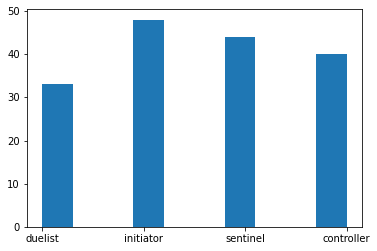

In [14]:
import matplotlib.pyplot as plt, mpld3
all_classes = []

for class_list in val_data['classes']:
    all_classes = all_classes + class_list

plt.hist(all_classes)
plt.show()

Imma plot the frequency of characters now by doing similar thing

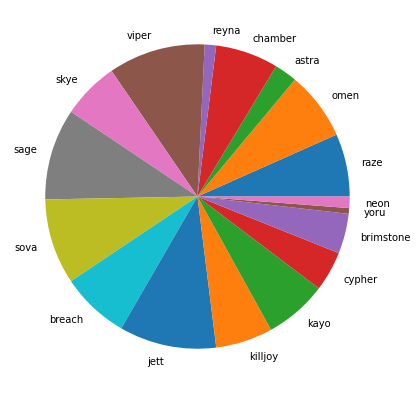

In [19]:
all_agents = []

for agent_list in val_data['Agents']:
    all_agents = all_agents + agent_list

for i in range(all_agents.count('(+2)')):
    all_agents.remove('(+2)')

for i in range(all_agents.count('(+1)')):
    all_agents.remove('(+1)')

counts = {i:all_agents.count(i) for i in set(all_agents)}

fig = plt.figure(figsize =(10, 7))
plt.pie(counts.values(), labels=counts.keys(), normalize=True)
plt.show()

Imma plot kills per round and average damage per round cuz i think they have a linear relationship

                            OLS Regression Results                            
Dep. Variable:                    KPR   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     337.6
Date:                Thu, 12 May 2022   Prob (F-statistic):           7.45e-26
Time:                        23:25:50   Log-Likelihood:                 109.26
No. Observations:                  60   AIC:                            -214.5
Df Residuals:                      58   BIC:                            -210.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0220      0.039     -0.558      0.5

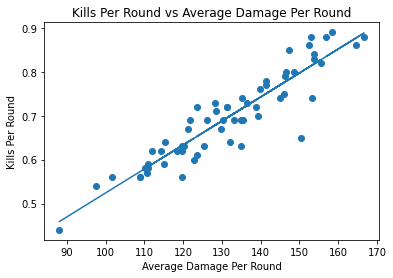

In [21]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

X = val_data['ADR']
y = val_data['KPR']
X2 = sm.add_constant(X)
reg = sm.OLS(y, X2).fit()

print(reg.summary())
plt.plot(X, reg.predict([[1,i] for i in X]))
plt.scatter(val_data['ADR'], val_data['KPR'])
plt.xlabel('Average Damage Per Round')
plt.ylabel('Kills Per Round')
plt.title('Kills Per Round vs Average Damage Per Round')
plt.show()

Things to note: 
p-val is 0 which means this is statistically significant (aka we reject the null hypothesis)
r-square value is .853 indicating a strong correlation

Ok but does kills correlate with wins?

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8036
Date:                Thu, 12 May 2022   Prob (F-statistic):              0.374
Time:                        23:26:16   Log-Likelihood:                -212.08
No. Observations:                  60   AIC:                             428.2
Df Residuals:                      58   BIC:                             432.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9887      7.492      0.933      0.3

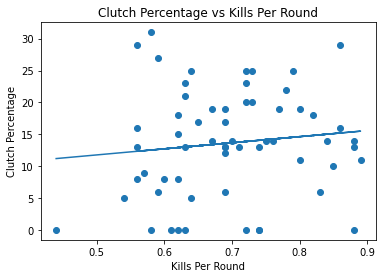

In [23]:
X = val_data['KPR']
y = [int((x[:-1])) for x in val_data['CL%']]

X2 = sm.add_constant(X)
reg = sm.OLS(y, X2).fit()

print(reg.summary())
plt.plot(X, reg.predict([[1,i] for i in X]))
plt.scatter(val_data['KPR'], y)
plt.xlabel('Kills Per Round')
plt.ylabel('Clutch Percentage')
plt.title('Clutch Percentage vs Kills Per Round')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                   0.01145
Date:                Thu, 12 May 2022   Prob (F-statistic):              0.915
Time:                        23:27:33   Log-Likelihood:                -212.48
No. Observations:                  60   AIC:                             429.0
Df Residuals:                      58   BIC:                             433.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.2748      3.526      3.764      0.0

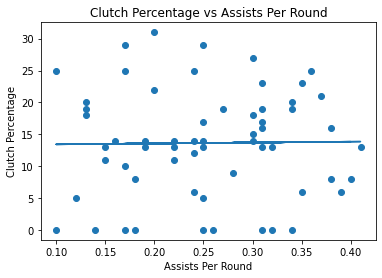

In [24]:
X = val_data[list(all_agents)]
y = [int((x[:-1])) for x in val_data['CL%']]

X2 = sm.add_constant(X)
reg = sm.OLS(y, X2).fit()

print(reg.summary())
plt.plot(X, reg.predict([[1,i] for i in X]))
plt.scatter(val_data['APR'], y)
plt.xlabel('')
plt.ylabel('Clutch Percentage')
plt.title('Clutch Percentage vs Assists Per Round')
plt.show()

In [ ]:
X = val_data['APR']
y = [int((x[:-1])) for x in val_data['CL%']]

X2 = sm.add_constant(X)
reg = sm.OLS(y, X2).fit()

print(reg.summary())
plt.plot(X, reg.predict([[1,i] for i in X]))
plt.scatter(val_data['APR'], y)
plt.xlabel('Assists Per Round')
plt.ylabel('Clutch Percentage')
plt.title('Clutch Percentage vs Assists Per Round')
plt.show()

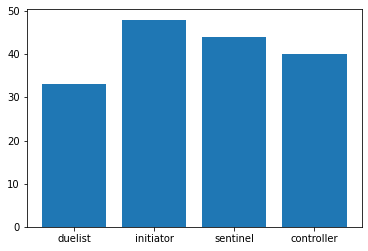

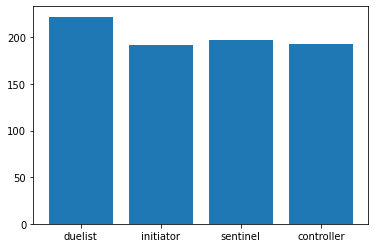

In [28]:
#lets plot the classes and their acs
classes_acs = {'duelist':0,'initiator':0,'sentinel':0,'controller':0}
classes_freq = {'duelist':0,'initiator':0,'sentinel':0,'controller':0}

for i, row in val_data.iterrows():
    for classes in row['classes']:
        classes_acs[classes] += row['ACS']
        classes_freq[classes] += 1
        
for key in classes_acs.keys():
    classes_acs[key] = classes_acs[key] / classes_freq[key]
    
plt.bar(classes_acs.keys(), classes_freq.values())
plt.show()
plt.bar(classes_acs.keys(), classes_acs.values())
plt.show()

# Analysis

# Insights

# Additional Resources